In [1]:
import pandas as pd
import numpy as np

from darts import TimeSeries
from darts.models import ExponentialSmoothing, NBEATSModel, NLinearModel, RNNModel, TCNModel, TransformerModel

import matplotlib.pyplot as plt
import seaborn as sns

import torch
torch.set_float32_matmul_precision('medium')

import time
import random

from tqdm.notebook import trange

import os
import contextlib

import logging
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)

from experimental_config import Experiment

# Playground

In [29]:
df = pd.read_parquet('stock_data.parquet')
df.head()

pivot_table = df.pivot_table(index='date', columns='ticker', values='prc')

# Drop all columns with nans
pivot_table = pivot_table.dropna(axis=1, how='any')

# create an index of dates with business day frequency
idx = pd.date_range(start=pivot_table.index.min(), end=pivot_table.index.max(), freq='B')
# reindex the pivot table with the new index
pivot_table = pivot_table.reindex(idx)
# fill the missing values with the previous value
pivot_table = pivot_table.fillna(method='ffill')

# # Turn data in pivot table into difference from previous timestep
# pivot_table = pivot_table.diff()
#
# # Drop first row of data
# pivot_table = pivot_table.iloc[1:]


print(pivot_table.index.min())
print(pivot_table.index.max())
pivot_table.index.name = 'date'
final_df = pivot_table.reset_index()
final_df = pd.DataFrame(final_df.values, columns=final_df.columns.to_list())
final_df

2020-01-02 00:00:00
2022-03-31 00:00:00


,date,A,AA,AAL,AAP,AAPL,AAS,ABBV,ABC,ABD,...,YRCW,YUM,YUMC,Z,ZBH,ZBRA,ZION,ZMH,ZTS,ZY
0,2020-01-02,85.949997,29.516001,29.09,159.410004,300.350006,70.540001,89.550003,85.080002,88.959999,...,2.58,102.169998,49.130001,41.288182,149.199997,259.140015,52.439999,149.199997,134.139999,61.700001
1,2020-01-03,84.57,29.492,27.65,159.419998,297.429993,69.896667,88.699997,84.010002,87.905004,...,2.57,101.849998,48.419998,41.08,148.809998,256.049988,51.700001,148.809998,134.160004,61.240002
2,2020-01-06,84.82,29.167999,27.32,156.800003,299.799988,70.073334,89.400002,85.239998,94.059997,...,2.56,101.790001,47.869999,41.410909,147.949997,258.01001,51.07,147.949997,133.130005,61.630001
3,2020-01-07,85.080002,29.392,27.219999,154.940002,298.390015,69.529999,88.889999,84.629997,94.610003,...,2.55,101.970001,47.93,42.215454,147.820007,256.470001,50.759998,147.820007,133.580002,61.59
4,2020-01-08,85.919998,28.667999,27.84,153.160004,303.190002,70.396665,89.519997,85.449997,93.765001,...,2.41,102.150002,48.540001,42.180909,149.589996,247.639999,51.259998,149.589996,133.289993,61.919998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,2022-03-25,135.710007,47.992,17.01,215.580002,174.720001,79.363335,161.330002,154.690002,163.535002,...,7.9,119.620003,41.259998,40.074545,125.279999,425.660004,71.080002,125.279999,189.429993,46.732501
582,2022-03-28,135.419998,47.684001,17.299999,210.490005,175.600006,78.816666,161.970001,154.729996,164.999999,...,7.81,121.190002,42.18,40.225455,125.68,422.279999,69.730003,125.68,189.369995,47.22
583,2022-03-29,138.419998,47.518001,18.16,215.449997,178.960007,79.206665,162.179993,155.039993,169.92,...,7.93,122.220001,43.560001,42.145454,129.580002,438.100006,69.739998,129.580002,192.279999,49.002498
584,2022-03-30,135.460007,47.589999,18.049999,211.820007,177.770004,78.813334,163.75,155.139999,168.340005,...,7.49,120.839996,43.709999,40.2,128.690002,429.609985,67.370003,128.690002,191.320007,47.255


In [6]:
t1 = time.time()

tickers = final_df.columns.to_list()[1:50]
big_ts = TimeSeries.from_dataframe(final_df, 'date', tickers)
train, val = big_ts.split_after(pd.Timestamp('2021-12-01'))
other_val = val[:10]
model = NLinearModel(
    input_chunk_length=120,
    output_chunk_length=30,
    n_epochs=100,
    random_state=0
)
model.fit(train, verbose = False)
new_train = train.append(other_val)

pred_1 = model.predict(len(val), series = train, verbose = False).pd_dataframe()
pred_2 = model.predict(len(val), series = new_train, verbose = False).pd_dataframe()

print(pred_1.index.max())
print(pred_2.index.max())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2022-03-31 00:00:00
2022-04-14 00:00:00


# Experiment Generation

1. Choose a random day between 2002-01-01 and 2021-12-31
2. Subset the data set going back 3 years from the given day and forward 30 days from the given day
3. Drop stocks which are missing data in the subset
4. Choose $n$ stocks from the subset
5. Split the subset into a training set and a validation set
6. Train the model on the training set
7. Predict the validation set
8. Calculate the mean absolute error of the prediction
9. Update series and validation set with truth values
10. Repeat steps 6-8 until the end of the validation set
11. calculate the mean absolute error of the entire validation set for each prediction and store
12. Package all the info into an object

## Data Import

In [23]:
# read in the price data
df = pd.read_parquet('spx_stock_prices.parquet')
df.index = pd.to_datetime(df.index)

# Randomly choose a date between 2002-01-01 and 2021-12-31
minimum_date = pd.Timestamp('2002-01-01')
maximum_date = pd.Timestamp('2021-12-31')
random_date = pd.Timestamp(random.randint(minimum_date.value, minimum_date.value))
random_date = random_date.date()

# get the date two years before random date
start_date = random_date - pd.DateOffset(years=3)
# get the date 30 business days after random date
end_date = random_date + pd.DateOffset(days=30)
# convert random date to a string
random_date = random_date.strftime('%Y-%m-%d')
start_date = start_date.strftime('%Y-%m-%d')
end_date = end_date.strftime('%Y-%m-%d')

# Subset the data
subset = df.loc[start_date:end_date]

# Replace all zeros with nan
subset = subset.replace(0, np.nan)

# Drop all columns with nans
subset = subset.dropna(axis=1, how='any')

# Select a number between 20 and 50
n = random.randint(20, 50)

# Choose n stocks from the subset
stocks = random.sample(subset.columns.to_list(), n)

# select the stocks from the subset
subset = subset[stocks]

# Get the average percent change variance of the stocks
variance = subset.pct_change().var().mean()

# Reindex the subset with business days and set the index name to 'date'
subset = subset.reindex(pd.date_range(start=subset.index.min(), end=subset.index.max(), freq='B'))
subset.index.name = 'date'

# Fill the missing values with the previous value
subset = subset.fillna(method='ffill')
split_date = subset.index[-31]

# Turn index into a column
subset = subset.reset_index()

# Create a TimeSeries object using subset
ts = TimeSeries.from_dataframe(subset, 'date', stocks)

# Split the TimeSeries into a training set and a validation set with the validation set being the last 30 time steps
train, val = ts.split_after(split_date)
truth = val.pd_dataframe()
model = NLinearModel(
    input_chunk_length=120,
    output_chunk_length=30,
    n_epochs=100,
    random_state=0
)

model.fit(train, verbose = False)
predictions = [None] * len(val)

for i in range(len(val)):
    # Supress print statements in this loop
    with open(os.devnull, 'w') as devnull:
        with contextlib.redirect_stdout(devnull):
            updated_split = subset.index[-31 + i]
            updated_train, updated_val = ts.split_after(updated_split)
            forward_steps = len(val) - i
            pred = model.predict(forward_steps, series = updated_train, verbose = False)
            if i != 0:
                df1 = val[:i].pd_dataframe()
                df2 = pred.pd_dataframe()
                combined_df = pd.concat([df1, df2])
                predictions[i] = combined_df
            else:
                predictions[i] = pred.pd_dataframe()

Experiment

In [2]:
# read in the price data


Start Date: 2007-10-04
End Date: 2010-11-03


Start Date: 2015-11-05
End Date: 2018-12-05
24.922847916557338


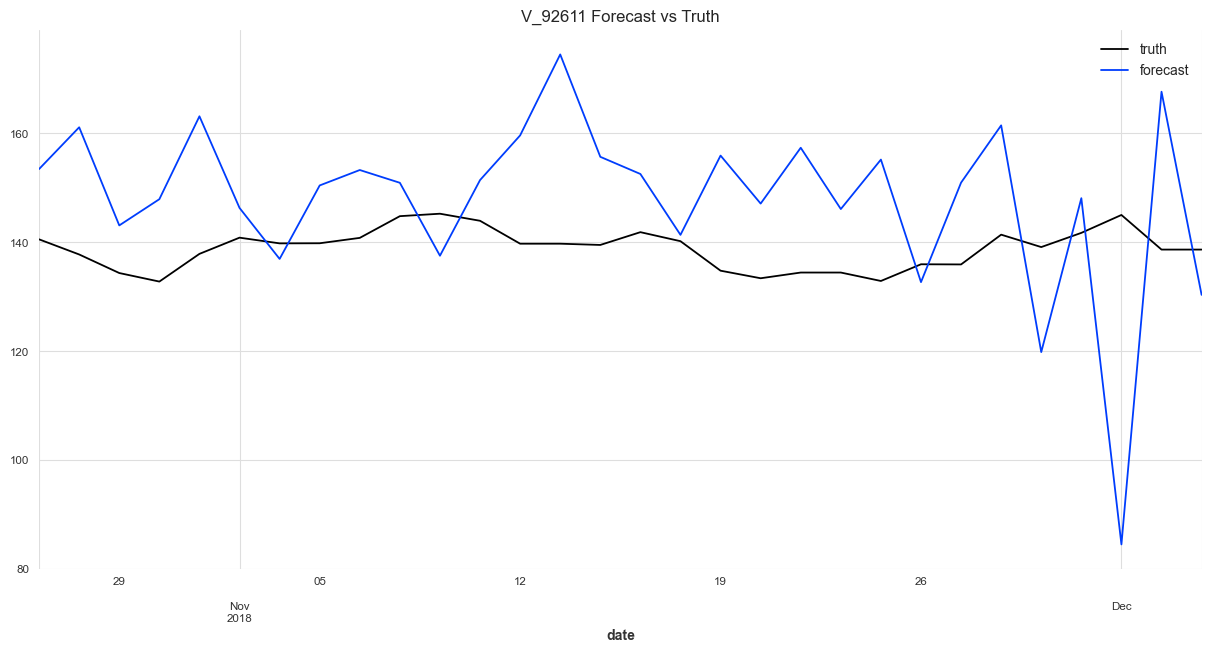

In [7]:
df = pd.read_parquet('spx_stock_prices.parquet')
df.index = pd.to_datetime(df.index)
exp = Experiment(df)
print(exp.average_error)
forecast = exp.forecasts[0]
truth = exp.truth
stock = exp.stocks[0]
fig, ax = plt.subplots(figsize=(15, 7))
truth[stock].plot(ax=ax, label='truth')
forecast[stock].plot(ax=ax, label='forecast')
ax.legend()
ax.set_title(f'{stock} Forecast vs Truth')
plt.show()

In [36]:
initial= train.pd_dataframe().iloc[-1]
initiak_port = np.zeros(len(initial))
(initiak_port + np.ones(len(initial))) @ initial < 1000000

True

In [29]:
train.pd_dataframe().index.max()

Timestamp('2004-03-09 00:00:00', freq='B')